## Imports

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image
from copy import deepcopy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from utils import *

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import permutation_importance 
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV
from sklearn.neural_network import MLPRegressor

import warnings
warnings.filterwarnings('ignore')

# Part 1

## Load Data

In [33]:
# Data paths
labeled_data_path = '../data/data_labeled/'
unlabeled_data_path = '../data/data_unlabeled/'

# Image paths
img_test_unlabeled_path = '../data/data_labeled/Img_test/'
img_train_unlabeled_path = '../data/data_labeled/Img_train/'
X_img_path = '../data/data_unlabeled/Img/'

# Load csv's
X_test = pd.read_csv(labeled_data_path + 'X_test.csv')
X_train = pd.read_csv(labeled_data_path + 'X_train.csv')
y_test = pd.read_csv(labeled_data_path + 'y_test.csv', header=None)
y_train = pd.read_csv(labeled_data_path + 'y_train.csv', header=None)
X_unlabeled = pd.read_csv(unlabeled_data_path + 'X.csv')

X_test.head()

,age,blood pressure,calcium,cholesterol,hemoglobin,height,potassium,profession,sarsaparilla,smurfberry liquor,smurfin donuts,vitamin D,weight,img_filename
0,85,106.92,2.25,120.85,14.90,7.41,3.26,resource extraction,Low,High,Moderate,36.27,93.20,heart_0.png
1,130,94.73,2.61,121.74,16.88,7.53,4.74,manufacturing,Very high,Very high,Moderate,25.97,105.24,heart_6.png
2,180,110.31,2.47,75.35,15.52,8.02,4.29,manufacturing,High,Moderate,Very low,37.53,100.61,heart_7.png
3,78,95.46,2.28,125.30,11.68,7.75,4.17,services,Very low,Low,Moderate,28.19,103.94,heart_10.png
4,116,106.13,2.11,89.98,14.83,7.89,4.73,resource extraction,Low,Very high,Low,30.07,82.53,heart_11.png


## Preprocess Data

In [34]:

#Save data before cleaning
X_train_clean = X_train.copy()
X_test_clean = X_test.copy()
X_unlabeled_clean = X_unlabeled.copy()

X_train = X_train.drop(columns=['img_filename'])
X_test = X_test.drop(columns=['img_filename'])
X_unlabeled = X_unlabeled.drop(columns=['img_filename'])

X_train = pd.get_dummies(X_train, columns=['profession'])
X_test = pd.get_dummies(X_test, columns=['profession'])
X_unlabeled = pd.get_dummies(X_unlabeled, columns=['profession'])

# Ordinal encoding of consumption features
consumption_map = {
    'Very low': 1,
    'Low': 2,
    'Moderate': 3,
    'High': 4,
    'Very high': 5
}

for col in ['sarsaparilla', 'smurfberry liquor', 'smurfin donuts']:
    X_train[col] = X_train[col].map(consumption_map)
    X_test[col] = X_test[col].map(consumption_map)
    X_unlabeled[col] = X_unlabeled[col].map(consumption_map)
    
# Standardize numerical features
numerical_features = [
    'age', 'blood pressure', 'calcium', 'cholesterol',
    'hemoglobin', 'height', 'potassium',
    'vitamin D', 'weight'
]

X_train_original = X_train.copy()
X_test_original = X_test.copy()
X_unlabeled_original = X_unlabeled.copy()


## Feature Selection

### Filter

#### Mutual Information

In [35]:

mi_scores = mutual_info_regression(X_train, y_train.values.ravel(), random_state=42)
mi_df = pd.DataFrame({'Feature': X_train.columns, 'MI': mi_scores})
mi_df = mi_df.sort_values(by='MI', ascending=False).reset_index(drop=True)


mean_mi, std_mi = mi_df['MI'].mean(), mi_df['MI'].std()

threshold_soft = mean_mi + 0.3 * std_mi
selected_by_threshold = mi_df[mi_df['MI'] > threshold_soft]['Feature'].tolist()
print(len(selected_by_threshold))
# En cas de peu de sélection, garde toutes les features avec MI > 0
if len(selected_by_threshold) < 6:
    selected_by_threshold = mi_df[mi_df['MI'] > 0]['Feature'].tolist()

print(f"\n Seuil souple = {threshold_soft:.4f}")
print(f"{len(selected_by_threshold)} features retenues après filtrage MI :")
print(selected_by_threshold)

# Sous-ensembles correspondants
selected_features_mi = selected_by_threshold
X_train_mi = X_train[selected_features_mi].copy()
X_test_mi  = X_test[selected_features_mi].copy()
X_unlabeled_mi = X_unlabeled[selected_features_mi].copy()

4

 Seuil souple = 0.0610
14 features retenues après filtrage MI :
['blood pressure', 'cholesterol', 'weight', 'smurfin donuts', 'potassium', 'sarsaparilla', 'vitamin D', 'profession_administration and governance', 'age', 'hemoglobin', 'profession_services', 'profession_food production', 'profession_resource extraction', 'profession_manufacturing']


#### Maximum relevance and minimum redundancy

In [36]:
corr_matrix = X_train_mi.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = [col for col in upper.columns if any(upper[col] > 0.85)]
X_train_mrmr = X_train_mi.drop(columns=high_corr, errors='ignore')
#X_val_mrmr = X_val_mi.drop(columns=high_corr, errors='ignore')
X_test_mrmr = X_test_mi.drop(columns=high_corr, errors='ignore')
X_unlabeled_mrmr = X_unlabeled_mi.drop(columns=high_corr, errors='ignore')
y_train_ravel = y_train.values.ravel()
print(f"\n{len(high_corr)} variables redondantes supprimées après mRMR simplifié :")
print(high_corr)
print(f"{X_train_mrmr.shape[1]} features restantes après mRMR.")


0 variables redondantes supprimées après mRMR simplifié :
[]
14 features restantes après mRMR.


#### RF selection

In [37]:

rf_selector = RandomForestRegressor(n_estimators=100, random_state =42, n_jobs=-1)
rf_selector.fit(X_train_mrmr, y_train_ravel)

importances = rf_selector.feature_importances_
feature_names = X_train_mrmr.columns
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 des caractéristiques selon Random Forest Importance:")
print(feature_importances_df.head(10))


Top 10 des caractéristiques selon Random Forest Importance:
                           Feature  Importance
0                   blood pressure    0.581197
9                       hemoglobin    0.117307
4                        potassium    0.098481
2                           weight    0.044934
8                              age    0.043431
1                      cholesterol    0.039196
6                        vitamin D    0.027567
5                     sarsaparilla    0.019582
3                   smurfin donuts    0.010945
12  profession_resource extraction    0.004388


# Part 2

In [38]:
rmse_scorer_for_rfecv = make_scorer(compute_rmse, greater_is_better=False)
rf_estimator = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
print("Début de la sélection de caractéristiques RFECV (Cross-Validation) en utilisant la RMSE...")
rfecv_selector = RFECV(
    estimator=rf_estimator,
    step=1,
    cv=5,                             # Utilise 5 plis de Cross-Validation
    scoring=rmse_scorer_for_rfecv,    # Utilisation de votre RMSE scorer
    n_jobs=-1,
    verbose=1
)
rfecv_selector.fit(X_train_mrmr, y_train_ravel)

N_optimal = rfecv_selector.n_features_
print(f"\nNombre optimal de caractéristiques (N) déterminé par CV : {N_optimal}")
selected_features_rfecv = X_train_mrmr.columns[rfecv_selector.support_].tolist()
print("\nCaractéristiques sélectionnées :")
print(selected_features_rfecv)

X_train_part2 = X_train_mrmr[selected_features_rfecv].copy()
X_test_part2 = X_test_mrmr[selected_features_rfecv].copy()

Début de la sélection de caractéristiques RFECV (Cross-Validation) en utilisant la RMSE...
Fitting estimator with 14 features.
Fitting estimator with 14 features.
Fitting estimator with 14 features.
Fitting estimator with 14 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 13 features.
Fitting estimator with 13 features.
Fitting estimator with 13 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 12 features.
Fitting estimator with 12 features.
Fitting estimator with 12 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 11 features.
Fitting estimator with 11 features.
Fitting estimator with 11 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 10 features.
Fitting estimator with 10 features.
Fitting estimator with 10 features.
Fitting estimator with 10 features.
Fitting e

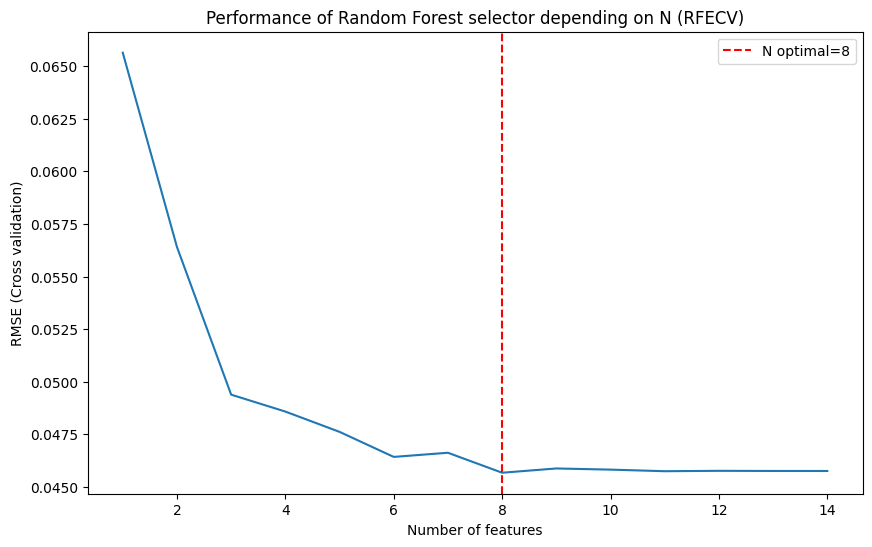

In [39]:

# Assuming it returns the actual RMSE values (since greater_is_better=False)
scores_rmse = -rfecv_selector.cv_results_['mean_test_score'] 
n_features_range = range(1, len(X_train_mrmr.columns) + 1)

# Création du graphique (nécessite matplotlib)
plt.figure(figsize=(10, 6))
plt.plot(n_features_range, scores_rmse)
plt.xlabel("Number of features")
plt.ylabel("RMSE (Cross validation)")
plt.title("Performance of Random Forest selector depending on N (RFECV)")
plt.axvline(x=N_optimal, color='r', linestyle='--', label=f'N optimal={N_optimal}')
plt.legend()
#plt.savefig("C:/Users/User/Desktop/GBIOM2/LELEC2870_Machine_learning/LELEC2870-Project/plots/performance_rf_selection.pdf")
plt.show()

In [ ]:
print("\n--- Optimisation du MLP (Simple) ---")

mlp_base_estimator = MLPRegressor(max_iter=500, random_state=42)

# Créer le Pipeline : Scaling puis MLP
pipe_mlp_fine_tune = Pipeline([
    ('scaler', StandardScaler()), 
    ('mlp', mlp_base_estimator) 
])
param_grid_mlp_final = {
    # Architectures à tester :
    # Essayer des configurations à 1 ou 2 couches
    # (40,) : 1 couche de 40 neurones (assez petite pour 12 features)
    # (40, 20) : 2 couches (40 puis 20)
    # (80, 40) : 2 couches plus larges
    'mlp__hidden_layer_sizes': [(40,20), (80, 40), (100, 60), (200, 120),(200,150), (250, 150),(300, 180),(400, 240), (600, 360)], 
    
    # Fonction d'activation (ReLU est standard et performante)
    'mlp__activation': ['relu'],
    
    # Terme de régularisation L2 (alpha)
    # Le MLP est sensible à l'overfitting, donc il faut tester la régularisation
    'mlp__alpha': [0.01],
    
    # Taux d'apprentissage initial
    'mlp__learning_rate_init': [0.016], 
    
    'mlp__solver': ['adam']
}
#Meilleurs hyperparamètres MLP : {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (400, 240), 'mlp__learning_rate_init': 0.01, 'mlp__solver': 'adam'}
# Fixer le nombre maximum d'itérations
# max_iter doit être suffisant pour que le réseau converge (souvent 500 ou 1000)
#mlp_estimator_final = MLPRegressor(max_iter=500, random_state=42)

mlp_grid_final = GridSearchCV(
    estimator=pipe_mlp_fine_tune,
    param_grid=param_grid_mlp_final,
    scoring=rmse_scorer_for_rfecv, # Utilisation du scorer RMSE négatif
    cv=5,
    n_jobs=-1,
    verbose=2
)

print("\n--- Optimisation du Multi-Layer Perceptron (MLP) ---")
print("Début du tuning MLP...")

# Entraînement et tuning sur les 12 caractéristiques
mlp_grid_final.fit(X_train_part2, y_train_ravel) 

# Extraction du résultat RMSE réel (inversion du signe)
best_rmse_val_mlp_final = -mlp_grid_final.best_score_ 

print(f"\nMeilleur RMSE (Validation Croisée MLP) : {best_rmse_val_mlp_final:.4f}")
print(f"Meilleurs hyperparamètres MLP : {mlp_grid_final.best_params_}")

# Sauvegarder le meilleur modèle pour la comparaison finale
best_mlp_model_final = mlp_grid_final.best_estimator_


import pandas as pd


# Assurez-vous d'utiliser l'objet mlp_grid après le fit final
results = pd.DataFrame(mlp_grid_final.cv_results_)

# Création d'une clé d'architecture simple pour le graphique
# Nous allons simplifier l'affichage du tuple (ex: (80, 40) devient '80-40')
def format_architecture(hls_tuple):
    if isinstance(hls_tuple, tuple):
        return '-'.join(map(str, hls_tuple))
    return str(hls_tuple)

results['Architecture_str'] = results['param_mlp__hidden_layer_sizes'].apply(format_architecture)

# Filtrer uniquement les résultats avec les meilleurs autres hyperparamètres 
# (activation='relu', alpha=0.015, learning_rate_init=0.015, solver='adam') 
# pour isoler l'effet de la taille des couches.

best_alpha = mlp_grid_final.best_params_['mlp__alpha']
best_lr = mlp_grid_final.best_params_['mlp__learning_rate_init']

filtered_results = results[
    (results['param_mlp__alpha'] == best_alpha) & 
    (results['param_mlp__learning_rate_init'] == best_lr) &
    (results['param_mlp__activation'] == 'relu') # Si vous n'avez testé que 'relu'
].copy()

# Calcul du RMSE réel (inverser le signe du score CV)
results['RMSE_CV'] = -results['mean_test_score']
plt.figure(figsize=(10, 6))

# Création du graphique : Architecture (X) vs RMSE (Y)
plt.plot(
    results['Architecture_str'], 
    results['RMSE_CV'], 
    marker='o', 
    linestyle='-', 
    color='#1f77b4'
)

# Marquage du meilleur score
min_rmse = results['RMSE_CV'].min()
best_arch = results.loc[results['RMSE_CV'].idxmin(), 'Architecture_str']
plt.axhline(y=min_rmse, color='r', linestyle='--', 
            label=f'Best RMSE ({min_rmse:.4f}) with {best_arch}')

plt.xlabel("Architecture of the network (hidden_layer_sizes)")
plt.ylabel("RMSE (Cross Validation)")
plt.title(f"Impact of architecture on MLP Performance (alpha={best_alpha}, lr={best_lr})")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("../plots/MLP_performance.pdf")
plt.show()


--- Optimisation du MLP (Simple) ---

--- Optimisation du Multi-Layer Perceptron (MLP) ---
Début du tuning MLP...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(80, 40), mlp__learning_rate_init=0.016, mlp__solver=adam; total time=   0.2s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(80, 40), mlp__learning_rate_init=0.016, mlp__solver=adam; total time=   0.2s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 60), mlp__learning_rate_init=0.016, mlp__solver=adam; total time=   0.3s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(80, 40), mlp__learning_rate_init=0.016, mlp__solver=adam; total time=   0.3s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 60), mlp__learning_rate_init=0.016, mlp__solver=adam; total time=   0.4s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(